# Mamba: Sequence Modeling with Selective State Spaces

Mamba was introduced in the paper:  “Mamba: Linear Time Sequence Modeling with Selective State Spaces” by Albert Gu and Tri Dao. 

Mamba is an expansion of State-Space Models (S4) which historically have been used for sequence modeling. Mamba is a linear time sequence model that uses a selective state space to reduce the computational complexity of the model. Unlike transformers, Mamba has a linear time complexity and can be trained on long sequences.

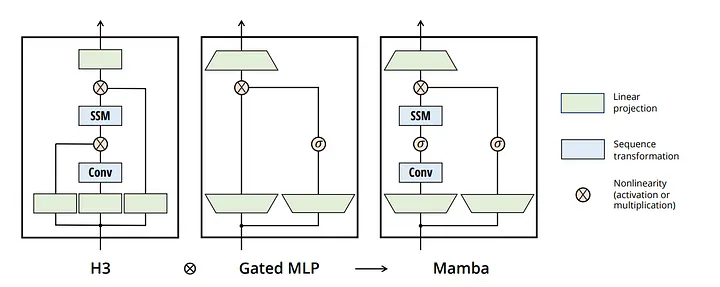

# References:

- [Mamba: Linear Time Sequence Modeling with Selective State Spaces](https://arxiv.org/abs/2110.06813)
- [Decoding Mamba: The Next Big Leap in AI Sequence Modeling](https://medium.com/ai-insights-cobet/decoding-mamba-the-next-big-leap-in-ai-sequence-modeling-ef3908060cb8)

In [1]:
import pandas as pd
import math
import random
import string
import os
import urllib.request
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
from tqdm import tqdm
from zipfile import ZipFile

#torch.autograd.set_detect_anomaly(True)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sequence_length = 512
batch_size_train = 64
batch_size_test = 1000

In [3]:
# Configuration flags and hyperparameters
USE_MAMBA = 1
DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM = 0

# Preprocess Data

In [4]:
def load_text(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    return text

In [5]:
def get_random_text_chunk(text: str, chunk_len: int = 200) -> str:
  start_index = random.randint(0, len(text) - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return text[start_index:end_index]

def get_random_batch(text: str, chunk_len: int = 200) -> tuple:
  text_chunk = get_random_text_chunk(text, chunk_len)
  input_seq, target_seq = text_chunk[:-1], text_chunk[1:]
  return (input_seq, target_seq)

def create_document_dataset(text: str, chunk_len: int = 200, dataset_size: int = 1000) -> pd.DataFrame:
    dataset = pd.DataFrame(columns=['input_ids', 'labels'])
    for _ in range(dataset_size):
        input_seq, target_seq = get_random_batch(text, chunk_len)
        dataset = pd.concat([dataset, pd.DataFrame({'input_ids': [input_seq], 'labels': [target_seq]})], ignore_index=True)
    return dataset

In [6]:
data_path = 'datasets/enwiki8'

if not os.path.exists(data_path):
    os.makedirs(data_path)
    download = True
else:
    download = False

if download:
    url = 'http://mattmahoney.net/dc/enwik8.zip'
    urllib.request.urlretrieve(url, data_path + '/enwik8.zip')
    with ZipFile(data_path + '/enwik8.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path)

text_raw = load_text(data_path + '/enwik8')

In [11]:
input_str, target_str = get_random_batch(text=text_raw, chunk_len=sequence_length)
print(f"The input string is: {input_str}")
print(f"The target string is: {target_str}")

The input string is: cation|SMILES]]
| &lt;small&gt;OC1=C(C(O[C@@H]1&lt;br&gt;[C@H](CO)O)=O)O&lt;/small&gt;
|-
| colspan=&quot;2&quot; align=&quot;center&quot; | [[Image:Ascorbic acid.png|chemical structure of L-Ascorbic acid]]
|} 

:''This article deals with the molecule ascorbic acid in General, for the nutrient see [[Vitamin C]]''

'''Ascorbic acid''' is an [[organic_chemistry| organic]] acid with [[antioxidant]] properties. Its appearance is  white to light yellow crystals or powder. It is water soluble. The L-[[enantiomer]
The target string is: ation|SMILES]]
| &lt;small&gt;OC1=C(C(O[C@@H]1&lt;br&gt;[C@H](CO)O)=O)O&lt;/small&gt;
|-
| colspan=&quot;2&quot; align=&quot;center&quot; | [[Image:Ascorbic acid.png|chemical structure of L-Ascorbic acid]]
|} 

:''This article deals with the molecule ascorbic acid in General, for the nutrient see [[Vitamin C]]''

'''Ascorbic acid''' is an [[organic_chemistry| organic]] acid with [[antioxidant]] properties. Its appearance is  white to light 

In [9]:
train_df = create_document_dataset(text=text_raw, chunk_len=sequence_length, dataset_size=1000)
val_df = create_document_dataset(text=text_raw, chunk_len=sequence_length, dataset_size=100)

# Create Training, Validation and Test Sets

In [ ]:
class Enwiki8Dataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data.size(0))

    def __getitem__(self, idx):
        input_str = self.data['input_ids'].iloc[idx]
        target_str = self.data['labels'].iloc[idx]

        input_encodings = self.tokenizer(input_str, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_str, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': input_encodings['input_ids'],
            'attention_mask': input_encodings['attention_mask'],
            'labels': target_encodings['input_ids']
        }

In [ ]:
# Load a pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Create the datasets
train_dataset = Enwiki8Dataset(data=train_df, tokenizer=tokenizer, max_length=sequence_length)
val_dataset = Enwiki8Dataset(data=val_df, tokenizer=tokenizer, max_length=sequence_length)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=False)

In [ ]:
# Define a function for padding
def pad_sequences_3d(sequences, max_len=None, pad_value=0):
    # Assuming sequences is a tensor of shape (batch_size, seq_len, feature_size)
    batch_size, seq_len, feature_size = sequences.shape

    if max_len is None:
        max_len = seq_len + 1


    # Initialize padded_sequences with the pad_value
    padded_sequences = torch.full((batch_size, max_len, feature_size), fill_value=pad_value, dtype=sequences.dtype, device=sequences.device)
    # Pad each sequence to the max_len
    padded_sequences[:, :seq_len, :] = sequences

    return padded_sequences

# Create Mamba Model

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-6, device: str ='cuda'):
        super().__init__()
        self.eps = eps
        self.gain = nn.Parameter(torch.ones(normalized_shape, device=device))

    def forward(self, x: torch.Tensor):
        rms = torch.rsqrt((torch.mean(x.pow(2), dim=-1, keepdim=True) + self.eps))
        return x * rms * self.gain

In [ ]:
class S6(nn.Module):
    def __init__(self, batch_size, seq_len, d_model, state_size, device):
        super(S6, self).__init__()

        self.fc1 = nn.Linear(d_model, d_model, device=device)
        self.fc2 = nn.Linear(d_model, state_size, device=device)
        self.fc3 = nn.Linear(d_model, state_size, device=device)

        self.seq_len = seq_len
        self.d_model = d_model
        self.state_size = state_size

        self.A = nn.Parameter(F.normalize(torch.ones(d_model, state_size, device=device), p=2, dim=-1))
        nn.init.xavier_uniform_(self.A)

        self.B = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)
        self.C = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)

        self.delta = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)
        self.dA = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.dB = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)

        # h should have dimensions [batch_size, seq_len, d_model, state_size]
        self.h = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.y = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)


    def discretization(self):
        # discretization function is defined based on the MAMBA paper's description using ZOH on page 28
        # in Section C : Mechanics on Selective SSMs
        # See also "Zero-order hold discretization" maths proof inside https://studywolf.wordpress.com/tag/zero-order-hold/
        """
        Here is an explanation of the mathematical rationale for the formulation of Δt used in Mamba:
        The key idea is that Δt controls the discretization rate of the continuous SSM dynamics. By making Δt input-dependent, it introduces selectivity into the discrete transition matrices.
        Specifically, in Mamba they parameterize Δt as:
        Δt = τΔ(Parameter + sΔ(xt))
        Where:
        - Parameter is a learned scalar parameter that controls the baseline discretization rate
        - sΔ(xt) is a projection that makes Δt input-dependent by computing a value based on xt
        - τΔ(x) = softplus(x) transforms the result to be positive through the softplus nonlinearity
        The rationale for this formulation is:
        - Parameter provides a reasonable default discretization rate
        - sΔ(xt) injects input-dependence through the projection
        - softplus ensures Δt is positive as required to be a valid timestep
        - The projection sΔ allows the model to learn to modulate Δt based on the input xt
        - This modulation creates selectivity in how rapidly or slowly the states update
        So in summary, the learned input-dependent projection allows Δt, and thus the discrete dynamics, to become selective. The softplus and scalar parameter provide useful inductive biases on top of this flexibility.
        The end result is discrete transition matrices that are selective on the input, enabling powerful sequence modeling capabilities.
        Credit: Claude2 AI chatbot
        """

        # inverse() only supports square matrix
        #dB = torch.matmul(torch.inverse(A * delta), torch.matmul(dA - torch.eye(A.shape[0]), B))
        self.dB = torch.einsum("bld,bln->bldn", self.delta, self.B)

        # https://github.com/state-spaces/mamba/blob/0131c1e94a46fc9f70bcfc9d57962963bb2f0b9e/mamba_ssm/modules/mamba_simple.py#L240
        #dA = torch.matrix_exp(A * delta)  # matrix_exp() only supports square matrix
        self.dA = torch.exp(torch.einsum("bld,dn->bldn", self.delta, self.A))
        #print(f"self.dA.shape = {self.dA.shape}")
        #print(f"self.dA.requires_grad = {self.dA.requires_grad}")

        return self.dA, self.dB

    def forward(self, x):
        # Refer to Algorithm 2 in the MAMBA paper
        self.B = self.fc2(x)
        self.C = self.fc3(x)
        self.delta = F.softplus(self.fc1(x))

        # Uses ZOH as in MAMBA, Hungry Hippo still uses bilinear transform for discretization
        self.discretization()

        if DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:  # this will trigger in-place runtime error if without using `h_new`
          
            global current_batch_size
            current_batch_size = x.shape[0]

            if self.h.shape[0] != current_batch_size:
                #print("Adjusting h_new for the different batch size of input data `x`")
                different_batch_size = True

                # Resize self.h to match the current batch size
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h[:current_batch_size, ...]) + rearrange(x, "b l d -> b l d 1") * self.dB

            else:
                different_batch_size = False
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            self.y = torch.einsum('bln,bldn->bld', self.C, h_new)

            # Update self.h with the detached state of h_new
            # Only do this if retaining gradients for self.h is not necessary for backprop
            # Otherwise, store h_new in a temporary list and update self.h after the loop
            global temp_buffer
            temp_buffer = h_new.detach().clone() if not self.h.requires_grad else h_new.clone()
  
            return self.y

        else:  # this will not trigger in-place runtime error
            # h should have dimensions [batch_size, seq_len, d_model, state_size]
            h = torch.zeros(x.size(0), self.seq_len, self.d_model, self.state_size, device=x.device)
            y = torch.zeros_like(x)

            h =  torch.einsum('bldn,bldn->bldn', self.dA, h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            y = torch.einsum('bln,bldn->bld', self.C, h)

            return y

In [ ]:
class MambaBlock(nn.Module):
    def __init__(self, batch_size, seq_len, d_model, state_size, device):
        super(MambaBlock, self).__init__()

        self.inp_proj = nn.Linear(d_model, 2*d_model, device=device)
        self.out_proj = nn.Linear(2*d_model, d_model, device=device)

        # For residual skip connection
        self.D = nn.Linear(d_model, 2*d_model, device=device)

        # Set _no_weight_decay attribute on bias
        self.out_proj.bias._no_weight_decay = True

        # Initialize bias to a small constant value
        nn.init.constant_(self.out_proj.bias, 1.0)

        self.S6 = S6(batch_size, seq_len, 2*d_model, state_size, device)

        # Add 1D convolution with kernel size 3
        self.conv = nn.Conv1d(seq_len, seq_len, kernel_size=3, padding=1, device=device)

        # Add linear layer for conv output
        self.conv_linear = nn.Linear(2*d_model, 2*d_model, device=device)

        # rmsnorm
        self.norm = RMSNorm(d_model, device=device)

    def forward(self, x):
        """
        x_proj.shape = torch.Size([batch_size, seq_len, 2*d_model])
        x_conv.shape = torch.Size([batch_size, seq_len, 2*d_model])
        x_conv_act.shape = torch.Size([batch_size, seq_len, 2*d_model])
        """
        # Refer to Figure 3 in the MAMBA paper

        x = self.norm(x)

        x_proj = self.inp_proj(x)
        #print(f"x_proj.shape = {x_proj.shape}")

        # Add 1D convolution with kernel size 3
        x_conv = self.conv(x_proj)
        #print(f"x_conv.shape = {x_conv.shape}")

        x_conv_act = F.silu(x_conv)
        #print(f"x_conv_act.shape = {x_conv_act.shape}")

        # Add linear layer for conv output
        x_conv_out = self.conv_linear(x_conv_act)
        #print(f"x_conv_out.shape = {x_conv_out.shape}")

        x_ssm = self.S6(x_conv_out)
        x_act = F.silu(x_ssm)  # Swish activation can be implemented as x * sigmoid(x)
        #print(f"x_act.shape = {x_act.shape}")

        # residual skip connection with nonlinearity introduced by multiplication
        x_residual = F.silu(self.D(x))
        #print(f"x_residual.shape = {x_residual.shape}")
        x_combined = x_act * x_residual
        #print(f"x_combined.shape = {x_combined.shape}")

        x_out = self.out_proj(x_combined)
        #print(f"x_out.shape = {x_out.shape}")

        return x_out

In [ ]:
class Mamba(nn.Module):
    def __init__(self, batch_size, seq_len, d_model, state_size, device):
        super(Mamba, self).__init__()
        self.mamba_block1 = MambaBlock(batch_size, seq_len, d_model, state_size, device)
        self.mamba_block2 = MambaBlock(batch_size, seq_len, d_model, state_size, device)
        self.mamba_block3 = MambaBlock(batch_size, seq_len, d_model, state_size, device)

    def forward(self, x):
        x = self.mamba_block1(x)
        x = self.mamba_block2(x)
        x = self.mamba_block3(x)
        return x

# Training Loop

In [ ]:
def train_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []

    for batch in train_loader:
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        y_hat = model(input_ids)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

In [ ]:
def validate_classification(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

In [ ]:
def train(model, tokenizer, data_loader, optimizer, criterion, device, max_grad_norm=1.0, DEBUGGING_IS_ON=False):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_data = batch['input_ids'].clone().to(device)
        attention_mask = batch['attention_mask'].clone().to(device)

        # In most sequence modeling tasks, like language modeling, the target should be the next token
        # in the sequence rather than the input token itself.
        # This is because the model's goal is to predict the next word given the previous words.
        # Shift the input data by one position to get the target, so that each target token
        # is the next token following the input token.
        target = input_data[:, 1:]
        input_data = input_data[:, :-1]

        # Pad all the sequences in the batch:
        input_data = pad_sequences_3d(input_data, pad_value=tokenizer.pad_token_id)
        target = pad_sequences_3d(target, max_len=input_data.size(1), pad_value=tokenizer.pad_token_id)

        if USE_MAMBA:
            output = model(input_data)
            loss = criterion(output, target)

        loss.backward(retain_graph=True)

        # Clip gradients: gradients are modified in place
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        for name, param in model.named_parameters():
           if 'out_proj.bias' not in name:
               # clip weights but not bias for out_proj
               torch.nn.utils.clip_grad_norm_(param, max_norm=max_grad_norm)

        if DEBUGGING_IS_ON:
            for name, parameter in model.named_parameters():
                if parameter.grad is not None:
                    print(f"{name} gradient: {parameter.grad.data.norm(2)}")
                else:
                    print(f"{name} has no gradient")

        if USE_MAMBA and DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:
            model.S6.h[:current_batch_size, ...].copy_(temp_buffer)

        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_data = batch['input_ids'].clone().detach().to(device)
            attention_mask = batch['attention_mask'].clone().detach().to(device)

            # In most sequence modeling tasks, like language modeling, the target should be the next token
            # in the sequence rather than the input token itself.
            # This is because the model's goal is to predict the next word given the previous words.
            # Shift the input data by one position to get the target, so that each target token
            # is the next token following the input token.
            target = input_data[:, 1:]
            input_data = input_data[:, :-1]

            # Pad all the sequences in the batch:
            input_data = pad_sequences_3d(input_data, pad_value=tokenizer.pad_token_id)
            target = pad_sequences_3d(target, max_len=input_data.size(1), pad_value=tokenizer.pad_token_id)

            if USE_MAMBA:
                output = model(input_data)
                loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [ ]:
def calculate_perplexity(loss):
    return math.exp(loss)

In [ ]:
# User-defined hyperparameters
d_model = 8
state_size = 128  # Example state size
seq_len = 100  # Example sequence length
batch_size = 256  # Example batch size
last_batch_size = 81  # only for the very last batch of the dataset
current_batch_size = batch_size
different_batch_size = False
h_new = None
temp_buffer = None

In [ ]:
x = torch.rand(batch_size, seq_len, d_model, device=device)
# Create the Mamba model
mamba = Mamba(seq_len, d_model, state_size, device)

# rmsnorm
norm = RMSNorm(d_model)
x = norm(x)

# Forward pass
test_output = mamba(x)
print(f"test_output.shape = {test_output.shape}")  # Should be [batch_size, seq_len, d_model]

In [ ]:
# Initialize the model

model = Mamba(seq_len, d_model, state_size, device).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-6)

# Training loop
num_epochs = 25  # Number of epochs to train for

In [ ]:
for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    train_loss = train(model, tokenizer, train_loader, optimizer, criterion, device, max_grad_norm=10.0, DEBUGGING_IS_ON=False)
    val_loss = evaluate(model, val_loader, criterion, device)
    val_perplexity = calculate_perplexity(val_loss)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Perplexity: {val_perplexity:.4f}')

# Evaluate Model

# Inference